# Sanity check: velocity calculations

The purpose of this notebook is to make sure that the range_diff function is implemented correctly. We have already expanded it to be operable on a multidimensional array. Now, the goal is to make sure that the calculations align with more established methods. We will be attempting to compare with results from Irena Vankova's MATLAB ApRES processing scripts.

In [3]:
# Setting up environment
import sys
import pandas as pd
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    01:12:37 	 ApRESDefs.py @function _setup_logging line 494 - Stream logging level set to DEBUG
DEBUG    01:12:37 	 ApRESDefs.py @function _setup_logging line 495 - Add console handler to logger
DEBUG    01:12:37 	 ApRESDefs.py @function _setup_logging line 508 - File logging level set to DEBUG


In [2]:
# Loading site data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")


In [3]:
# Set up dask cluster to help with computation
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41867")
client

<Client: 'tcp://127.0.0.1:41867' processes=1 threads=4, memory=14.72 GiB>

# Comparing consecutive stacked bursts from 2 files

I've downloaded two files from the month of June. After some manual checking, I've found the first burst of the first file aligns with t=954, while the last burst of the second file aligns with t=1141. We load this in for station A101.

In [4]:
timeseries = ds_101.isel(attenuator_setting_pair = 0,time=range(954,1142)).profile_stacked.compute()


Now, let's calculate the velocities between each burst. We basically need to stagger the timeframes that we select by 1.

In [5]:
b1 = timeseries.isel(time=range(0,len(timeseries.time)-1))
b2 = timeseries.isel(time=range(1,len(timeseries.time)))


This will give the range difference between each burst, without any phase wrapping. We use a correlation window and step of 10.

In [53]:
ds = xa.generate_range_diff(b1,b2,19,19,None,0)

INFO     00:31:56 	 ApRESDefs.py @function generate_range_diff line 549 - Time between bursts : [899. 900. 904. 919. 867. 910. 900. 893. 905. 902. 900. 900. 900. 900.
 900. 914. 881. 899. 900. 898. 901. 901. 899. 901. 906. 901. 899. 900.
 897. 895. 900. 902. 898. 900. 900. 900. 900. 932. 866. 901. 900. 900.
 900. 900. 902. 897. 910. 900. 900. 901. 922. 870. 899. 900. 900. 899.
 901. 899. 901. 900. 900. 931. 868. 899. 900. 901. 900. 900. 900. 901.
 900. 900. 900. 900. 904. 900. 927. 868. 901. 899. 899. 901. 900. 900.
 900. 909. 900. 922. 878. 900. 900. 900. 900. 902. 898. 900. 900. 901.
 899. 920. 902. 877. 900. 900. 900. 900. 900. 901. 899. 900. 900. 923.
 868. 902. 898. 901. 900. 903. 898. 900. 900. 900. 900. 899. 901. 900.
 899. 901. 899. 900. 900. 901. 899. 901. 901. 902. 897. 900. 900. 900.
 901. 899. 900. 900. 903. 897. 900. 902. 900. 905. 893. 900. 900. 901.
 899. 901. 906. 901. 922. 870. 898. 902. 900. 900. 900. 900. 900. 931.
 867. 900. 900. 902. 901. 899. 900. 900. 900. 900. 8

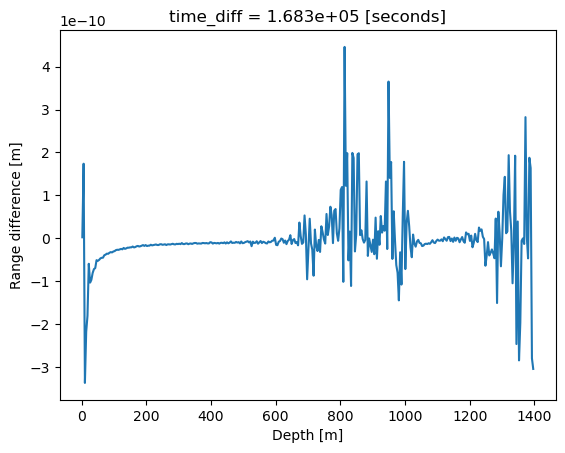

In [66]:
ds.range_diff.isel(time_diff=-1).plot()


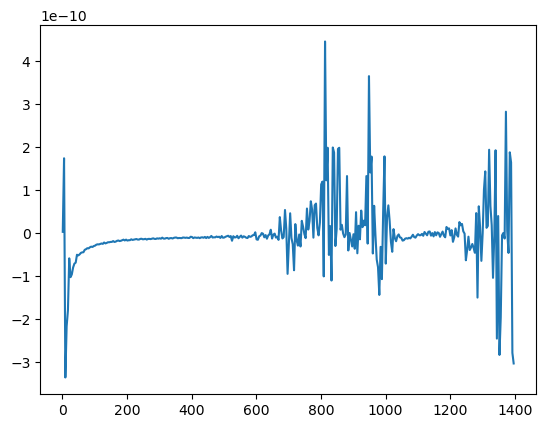

(array([ 39553.,  36066.,  54065.,  89810., 162533., 165217., 115294.,
         72042.,  43868.,  21572.]),
 array([-1.23184204, -0.98366165, -0.73548126, -0.48730087, -0.23912048,
         0.00905991,  0.2572403 ,  0.50542068,  0.75360107,  1.00178146,
         1.24996185]),
 <BarContainer object of 10 artists>)

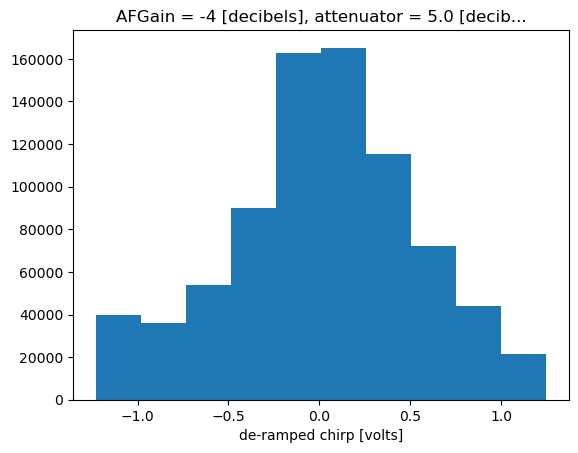

In [36]:
ds_101.isel(attenuator_setting_pair = 0, time = 6200).chirp.plot.hist()


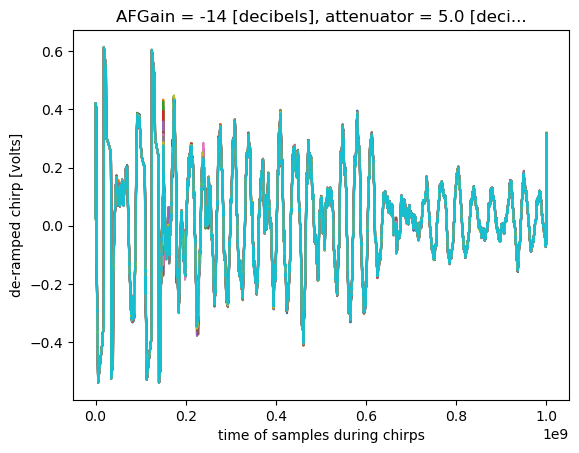

In [37]:
# check to make sure no clipping
for i in range(20):
    ds_101.isel(attenuator_setting_pair = 1, time = 6200, chirp_num=i).chirp.plot()


INFO     19:16:43 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 910.0s


<ErrorbarContainer object of 3 artists>

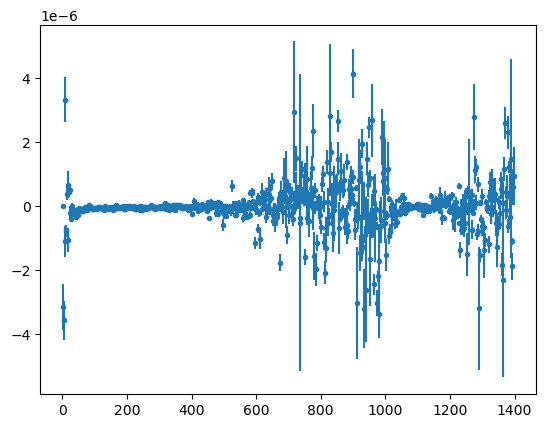

In [9]:
vels = xa.generate_range_diff(b1,b2,10,10)
plt.errorbar(vels.profile_range,vels.velocity,abs(vels.uncertainty),marker='.',linestyle='none')


In [15]:

b3 = ds_101.isel(attenuator_setting_pair = 1, time = 1100).profile_stacked.compute()


INFO     19:26:56 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 9001.0s
INFO     19:26:58 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 45010.0s
INFO     19:27:00 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 90002.0s
INFO     19:27:02 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 450006.0s


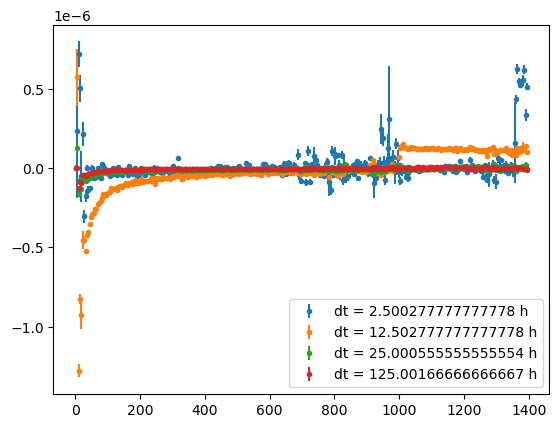

In [21]:
for t in [10,50,100,500]:
    b = ds_101.isel(attenuator_setting_pair = 1, time = 1000+t).profile_stacked.compute()
    dt = (b.time.data-b1.time.data)/ np.timedelta64(1, 'h')
    vels = xa.generate_range_diff(b1,b,20,20)
    plt.errorbar(vels.profile_range,vels.velocity,abs(vels.uncertainty),marker='.',linestyle='none',label=f"dt = {dt} h")
    
plt.legend()


Now after the lake drainage. Let's look in September

In [10]:
b3 = ds_101.isel(attenuator_setting_pair = 1, time = 11000).profile_stacked.compute()
b4 = ds_101.isel(attenuator_setting_pair = 1, time = 11001).profile_stacked.compute()
#download(str(b3.filename.data))
#download(str(b4.filename.data))

INFO     19:18:47 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 933.0s


<ErrorbarContainer object of 3 artists>

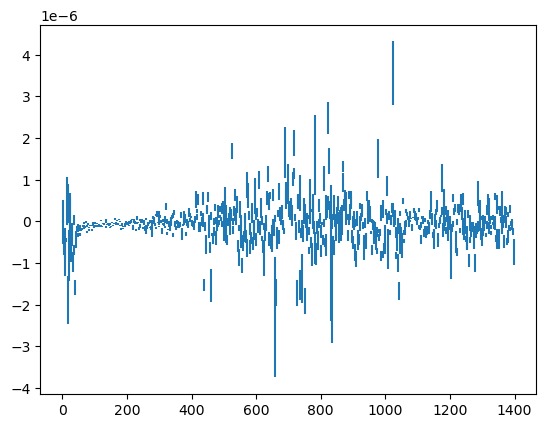

In [11]:
vels = xa.generate_range_diff(b3,b4,10,10)
plt.errorbar(vels.profile_range,vels.velocity,abs(vels.uncertainty),linestyle='none')


INFO     18:32:55 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 8998394.0s


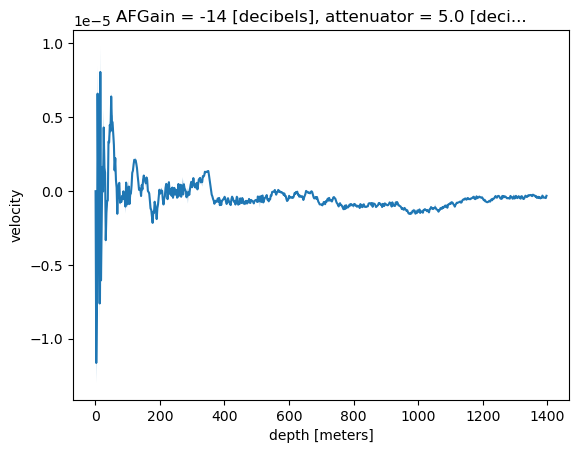

In [28]:
vels = xa.generate_range_diff(b2,b3,10,10)
vels.velocity.plot()
plt.fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

Interestingly much noisier.

# Comparing multiple bursts (stacked), weeks apart

We will do roughly 1 day stacked - 96 bursts

In [14]:
s1 = ds_101.isel(attenuator_setting_pair = 1, time = range(1000,1096)).profile_stacked.mean(dim='time').compute()
s1['time'] = ds_101.isel(attenuator_setting_pair = 1, time = range(1000,1096)).time.mean()
print(np.unique(ds_101.isel(attenuator_setting_pair = 1, time = range(1000,1096)).filename.compute()))

s2 = ds_101.isel(attenuator_setting_pair = 1, time = range(1672,1768)).profile_stacked.mean(dim='time').compute()
s2['time'] = ds_101.isel(attenuator_setting_pair = 1, time = range(1672,1768)).time.mean()
print(np.unique(ds_101.isel(attenuator_setting_pair = 1, time = range(1672,1768)).filename.compute()))


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-06-05-1036.DAT'
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-06-06-1006.DAT']


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-06-12-0706.DAT'
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-05-26-1536/DATA2022-06-13-0636.DAT']


(array([7.8470000e+03, 5.7360000e+03, 6.1200000e+03, 6.8910000e+03,
        9.4818000e+04, 1.4244100e+05, 4.9106000e+05, 2.7280220e+06,
        6.8173590e+06, 1.4340564e+07, 1.6571062e+07, 1.7146506e+07,
        1.1638100e+07, 4.1841040e+06, 1.6620950e+06, 7.0611200e+05,
        1.7284000e+05, 7.1881000e+04, 8.1730000e+03, 1.8900000e+02]),
 array([-0.49339294, -0.44541931, -0.39744568, -0.34947205, -0.30149841,
        -0.25352478, -0.20555115, -0.15757751, -0.10960388, -0.06163025,
        -0.01365662,  0.03431702,  0.08229065,  0.13026428,  0.17823792,
         0.22621155,  0.27418518,  0.32215881,  0.37013245,  0.41810608,
         0.46607971]),
 <BarContainer object of 20 artists>)

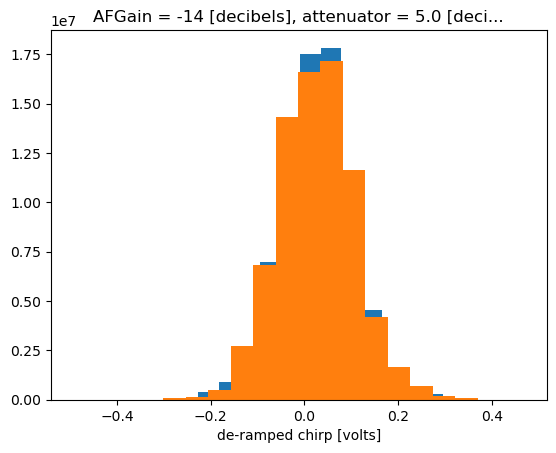

In [16]:
# check clipping
ds_101.isel(attenuator_setting_pair = 1, time = range(1000,1096)).chirp.plot.hist(bins=20)
ds_101.isel(attenuator_setting_pair = 1, time = range(1672,1768)).chirp.plot.hist(bins=20)


INFO     02:17:01 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 604805.135416666s


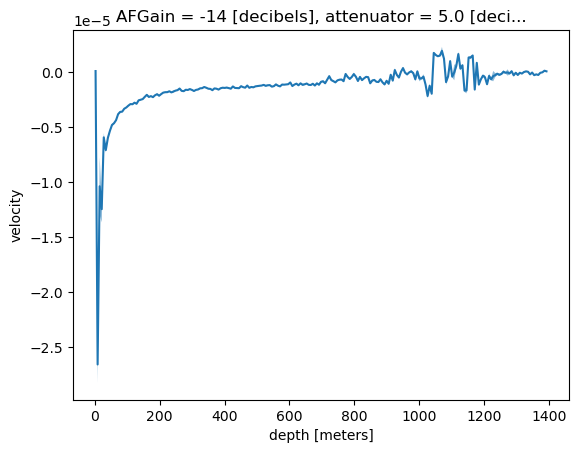

In [17]:
vels = xa.generate_range_diff(s1,s2,30,30)
vels.velocity.plot()
plt.fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

In [18]:
s3 = ds_101.isel(attenuator_setting_pair = 1, time = range(10000,10096)).profile_stacked.mean(dim='time').compute()
s3['time'] = ds_101.isel(attenuator_setting_pair = 1, time = range(10000,10096)).time.mean()
print(np.unique(ds_101.isel(attenuator_setting_pair = 1, time = range(10000,10096)).filename.compute()))

s4 = ds_101.isel(attenuator_setting_pair = 1, time = range(10672,10768)).profile_stacked.mean(dim='time').compute()
s4['time'] = ds_101.isel(attenuator_setting_pair = 1, time = range(10672,10768)).time.mean()
print(np.unique(ds_101.isel(attenuator_setting_pair = 1, time = range(10672,10768)).filename.compute()))


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-08-27-1154/DATA2022-09-07-0624.DAT'
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-08-27-1154/DATA2022-09-08-0554.DAT']


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


['ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-08-27-1154/DATA2022-09-14-0254.DAT'
 'ldeo-glaciology/GL_apres_2022/A101/CardA/DIR2022-08-27-1154/DATA2022-09-15-0224.DAT']


(array([7.0958000e+04, 1.4809000e+04, 5.8650000e+03, 4.1313000e+04,
        2.9680700e+05, 6.3276900e+05, 9.3925000e+05, 2.1851170e+06,
        6.8234420e+06, 1.3378284e+07, 2.3981286e+07, 1.6144178e+07,
        7.5982460e+06, 2.4248480e+06, 1.1790610e+06, 5.6862700e+05,
        2.6335200e+05, 8.8438000e+04, 5.4132000e+04, 1.1113800e+05]),
 array([-0.54691315, -0.49280739, -0.43870163, -0.38459587, -0.33049011,
        -0.27638435, -0.22227859, -0.16817284, -0.11406708, -0.05996132,
        -0.00585556,  0.0482502 ,  0.10235596,  0.15646172,  0.21056747,
         0.26467323,  0.31877899,  0.37288475,  0.42699051,  0.48109627,
         0.53520203]),
 <BarContainer object of 20 artists>)

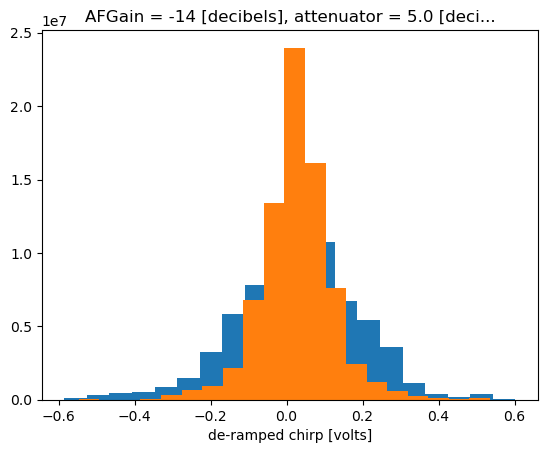

In [19]:
# check clipping
ds_101.isel(attenuator_setting_pair = 1, time = range(10000,10096)).chirp.plot.hist(bins=20)
ds_101.isel(attenuator_setting_pair = 1, time = range(10672,10768)).chirp.plot.hist(bins=20)


INFO     02:17:31 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 604806.333333333s


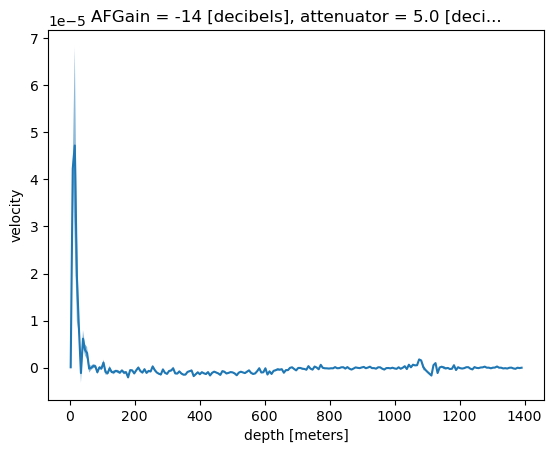

In [20]:
vels = xa.generate_range_diff(s3,s4,30,30)
vels.velocity.plot()
plt.fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

With 1 week apart, you still cannot see any kind of velocity

# Comparing the day-stacked bursts months apart

INFO     02:17:42 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 8099287.46875s


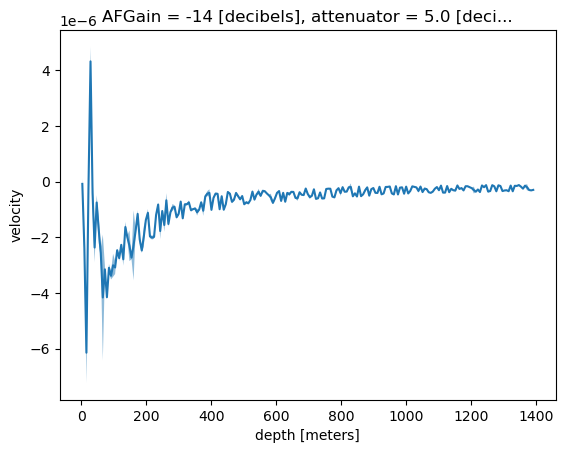

In [21]:
vels = xa.generate_range_diff(s1,s3,30,30)
vels.velocity.plot()
plt.fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

INFO     02:17:48 	 ApRESDefs.py @function generate_range_diff line 554 - Time between bursts : 8099288.666666667s


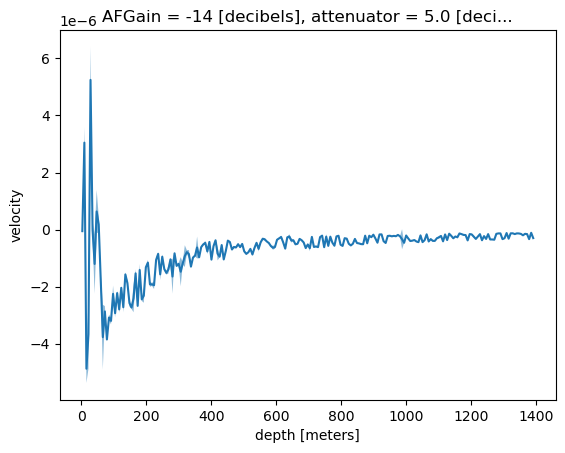

In [22]:
vels = xa.generate_range_diff(s2,s4,30,30)
vels.velocity.plot()
plt.fill_between(vels.profile_range,vels.velocity-vels.uncertainty,vels.velocity+vels.uncertainty,alpha=0.5)

I suspect stacking entire days might be too much

Stopping here to compare with MATLAB analysis before making additional changes. I suspect I need to build in a bulk alignment procedure of sorts. Also I will need to change the vertical velocities to a range difference (for now). I think it makes more sense that way.